# Road extraction from satellite images using U-net

In [1]:
# Importing relevant libraries
import pandas as pd
from PIL import Image
import cv2, os, tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Dropout, Conv2DTranspose, Concatenate, Lambda, BatchNormalization, Activation, LeakyReLU
from keras.utils.vis_utils import plot_model

In [3]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData(frameObj, imgPath, maskPath, shape):
    imgNames = os.listdir(imgPath)
    maskNames = []
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (1000):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [4]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/train', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/train'
                         , shape = 256)

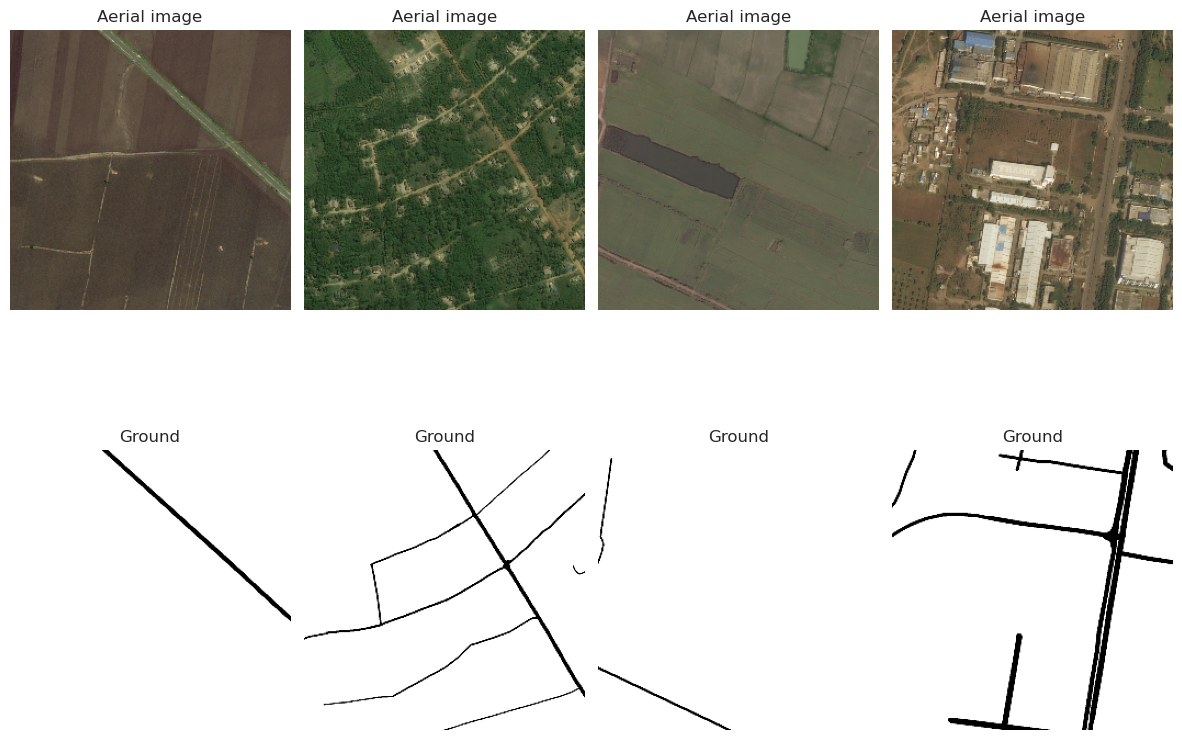

In [5]:
fig, ax = plt.subplots(figsize = (15, 10))
for i in range(1,5):
    idx = np.random.randint(1, 1000)
    mask =  np.array(framObjTrain['mask'][idx])
    image = np.array(framObjTrain['img'][idx])
    
    plt.subplot(2, 4, i)
    plt.imshow(image)
    plt.title('Aerial image')
    plt.axis("off")
    
    plt.subplot(2, 4, i + 4)
    plt.imshow(mask)
    plt.title('Ground')
    plt.axis("off")

plt.subplots_adjust(wspace=0.05)
plt.show()

In [6]:
NUMBER_OF_CHANNELS = 3

IMG_HEIGHT = 256
IMG_WIDTH = 256

KERNEL_SIZE = 3
POOL_SIZE = (2, 2)

UPSCALE_KERNEL_SIZE = 2
UPSCALE_STRIDE_SIZE = 2

FILTERS = 64

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, KERNEL_SIZE, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, KERNEL_SIZE, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def downscale_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    pool = MaxPool2D(POOL_SIZE)(x)
    return [pool, x]

def upscale_block(input_tensor, concat_tensor, num_filters):
    upscale  = Conv2DTranspose(num_filters, UPSCALE_KERNEL_SIZE, UPSCALE_STRIDE_SIZE, padding = "same")(input_tensor)
    new_tensor = Concatenate()([upscale, concat_tensor])
    x = conv_block(new_tensor, num_filters)
    return x

def U_net(input_shape, filters):
    input_tensor = Input(input_shape)
    input_tenosr = Lambda(lambda x : x/255)(input_tensor)
    
    downscale_1 = downscale_block(input_tensor, filters*1)
    downscale_2 = downscale_block(downscale_1[0], filters*2)
    downscale_3 = downscale_block(downscale_2[0], filters*4)
    downscale_4 = downscale_block(downscale_3[0], filters*8)
    downscale_5 = downscale_block(downscale_4[0], filters*16)
    
    mid_conv = conv_block(downscale_5[0], filters*32)
    
    upscale_1 = upscale_block(mid_conv, downscale_5[1], filters*16)
    upscale_2 = upscale_block(upscale_1, downscale_4[1], filters*8)
    upscale_3 = upscale_block(upscale_2, downscale_3[1], filters*4)
    upscale_4 = upscale_block(upscale_3, downscale_2[1], filters*2)
    upscale_5 = upscale_block(upscale_4, downscale_1[1], filters*1)
    
    output_tensor = Conv2D(1, 1, padding="same", activation="relu")(upscale_5)
    
    model = Model(inputs = input_tensor, outputs = output_tensor)
    return model

In [7]:
Unet =U_net((IMG_HEIGHT, IMG_HEIGHT, NUMBER_OF_CHANNELS), FILTERS)
Unet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='binary_crossentropy')

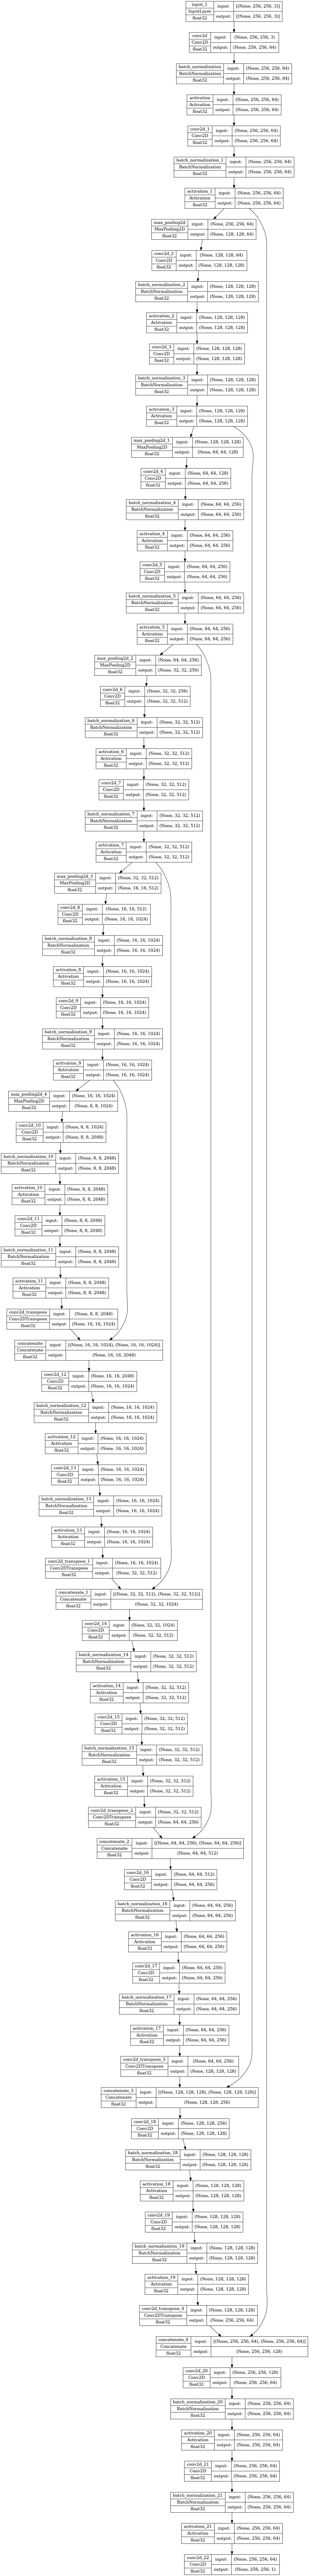

In [8]:
plot_model(Unet, to_file="/kaggle/working/U-net.png", show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
training_history_1 = Unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 40, verbose = 1)

Epoch 1/40
32/32 [==============================] - 60s 967ms/step - loss: 0.5315
Epoch 2/40
32/32 [==============================] - 28s 890ms/step - loss: 0.2111
Epoch 3/40
32/32 [==============================] - 28s 890ms/step - loss: 0.1731
Epoch 4/40
32/32 [==============================] - 28s 889ms/step - loss: 0.1635
Epoch 5/40
32/32 [==============================] - 28s 890ms/step - loss: 0.1673
Epoch 6/40
32/32 [==============================] - 29s 891ms/step - loss: 0.1659
Epoch 7/40
32/32 [==============================] - 29s 891ms/step - loss: 0.1634
Epoch 8/40
32/32 [==============================] - 29s 891ms/step - loss: 0.1588
Epoch 9/40
32/32 [==============================] - 29s 892ms/step - loss: 0.1528
Epoch 10/40
32/32 [==============================] - 29s 892ms/step - loss: 0.1512
Epoch 11/40
32/32 [==============================] - 29s 892ms/step - loss: 0.1642
Epoch 12/40
32/32 [==============================] - 29s 892ms/step - loss: 0.1573
Epoch 13/40
3

In [ ]:
plt.plot(training_history_1.history["loss"])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
for i in range(1,5):
    idx = np.random.randint(1, 1000)
    mask =  np.array(framObjTrain['mask'][idx])
    image = np.array(framObjTrain['img'][idx])
    predicted = Unet.predict(tf.expand_dims(image, axis=0))[0]
    
    plt.subplot(3, 4, i)
    plt.imshow(image)
    plt.title('Aerial image')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 4)
    plt.imshow(mask)
    plt.title('Ground')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 8)
    plt.imshow(predicted)
    plt.title('Predicted')
    plt.axis("off")

plt.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
Unet.save('/kaggle/working/1st_try.h5')

In [ ]:
thres = 0.0459
fig, ax = plt.subplots(figsize = (15, 10))
for i in range(1,5):
    idx = np.random.randint(1, 1000)
    mask =  np.array(framObjTrain['mask'][idx])
    image = np.array(framObjTrain['img'][idx])
    predicted = np.where(Unet.predict(tf.expand_dims(image, axis=0))[0] >= thres, 1, 0)
    
    plt.subplot(3, 4, i)
    plt.imshow(image)
    plt.title('Aerial image')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 4)
    plt.imshow(mask)
    plt.title('Ground')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 8)
    plt.imshow(predicted)
    plt.title('Predicted')
    plt.axis("off")

plt.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
import os

def test_predict(image_path, output_dir):
    # Load the image
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    
    # Predict mask
    predicted_mask = Unet.predict(input_arr)[0]
    
    # Save predicted mask image
    output_image_path = os.path.join(output_dir, os.path.basename(image_path).split('.')[0] + '_predicted_mask.png')
    plt.imsave(output_image_path, predicted_mask.squeeze(), cmap='gray')
    
    # Plotting
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(predicted_mask.squeeze(), cmap='jet', alpha=0.5)
    plt.title('Overlay')
    plt.axis("off")
    
    plt.show()
    
    return output_image_path

In [ ]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

'''Adjust the times parameter to increase or decrease the amount of sharpening.'''

def sharpen_image(image_path, times=1):
    # Open the image
    img = Image.open(image_path)
    
    # Convert the image to grayscale if it's not already
    img = img.convert('L')
    
    # Apply sharpening filter multiple times
    for _ in range(times):
        img = img.filter(ImageFilter.SHARPEN)

    return img

In [ ]:
image_path = "/kaggle/input/satellite-test-images/vit1 (1).jpg"
image1 = test_predict(image_path, "/kaggle/working/")
print("Output image saved at:", image1)

In [ ]:
image_path = "/kaggle/input/vit-satellite-image/Screenshot 2024-04-23 at 7.14.55PM.png"
image1 = test_predict(image_path, "/kaggle/working/")
print("Output image saved at:", image1)

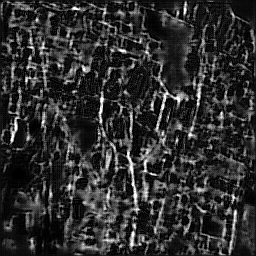

In [24]:
sharpen_image(image1, 2)

1/1 [==============================] - 0s 22ms/step


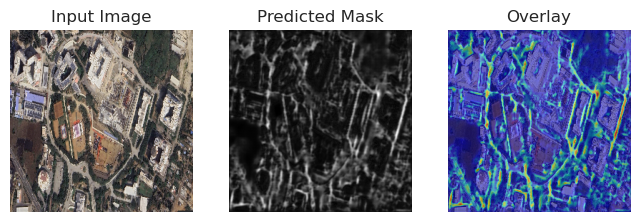

Output image saved at: /kaggle/working/Screenshot 2024-04-23 at 7_predicted_mask.png


In [26]:
image_path = "/kaggle/input/vit-satellite-image2/Screenshot 2024-04-23 at 7.33.55PM.png"
image2 = test_predict(image_path, "/kaggle/working/")
print("Output image saved at:", image1)

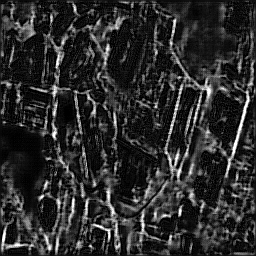

In [27]:
sharpen_image(image2, 2)